# About  the data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

# Data Dictionary
1. Datetime: Timestamp column for every hour
2. PJMW_MW: estimated energy consumption in Megawatts (MW)



# Content
1. Trend across hour, date, day, weekday, weekend, month, year 
2. Distribution of energy consumption across time periods and seasons
3. Outliers and Missing values
4. Autocorrelation and Partial correlation
5. Decomposition
6. Rolling Statistics
7. Checking for seasonality, stationary
8. Forecast vs Actuals with prophet and XGBoost model

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [13]:
power_forecasting=pd.read_csv('PJMW_hourly.csv')
power_forecasting.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [14]:
power_forecasting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [15]:
power_forecasting['Datetime'] = pd.to_datetime(power_forecasting['Datetime'], format='%Y-%m-%d %H:%M:%S')

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    

power_forecasting['date']=power_forecasting['Datetime'].dt.date
power_forecasting['day']=power_forecasting['Datetime'].dt.day 
power_forecasting['month']=power_forecasting['Datetime'].dt.month
power_forecasting['year']=power_forecasting['Datetime'].dt.year 
power_forecasting['hour']=power_forecasting['Datetime'].dt.hour
power_forecasting['weekday_name']=power_forecasting['Datetime'].dt.day_name()
power_forecasting['season'] = power_forecasting['month'].apply(get_season)
power_forecasting['quarter'] = power_forecasting['Datetime'].dt.quarter
power_forecasting['week_of_year'] = power_forecasting['Datetime'].dt.isocalendar().week
power_forecasting['day_of_year'] = power_forecasting['Datetime'].dt.dayofyear
power_forecasting['week_type']=power_forecasting['Datetime'].dt.weekday.apply(lambda x:'Weekend' if x>=5 else 'Weekday')
power_forecasting.head()

,Datetime,PJMW_MW,date,day,month,year,hour,weekday_name,season,quarter,week_of_year,day_of_year,week_type
0,2002-12-31 01:00:00,5077.0,2002-12-31,31,12,2002,1,Tuesday,Winter,4,1,365,Weekday
1,2002-12-31 02:00:00,4939.0,2002-12-31,31,12,2002,2,Tuesday,Winter,4,1,365,Weekday
2,2002-12-31 03:00:00,4885.0,2002-12-31,31,12,2002,3,Tuesday,Winter,4,1,365,Weekday
3,2002-12-31 04:00:00,4857.0,2002-12-31,31,12,2002,4,Tuesday,Winter,4,1,365,Weekday
4,2002-12-31 05:00:00,4930.0,2002-12-31,31,12,2002,5,Tuesday,Winter,4,1,365,Weekday


In [16]:
power_forecasting.columns

Index(['Datetime', 'PJMW_MW', 'date', 'day', 'month', 'year', 'hour',
       'weekday_name', 'season', 'quarter', 'week_of_year', 'day_of_year',
       'week_type'],
      dtype='object')

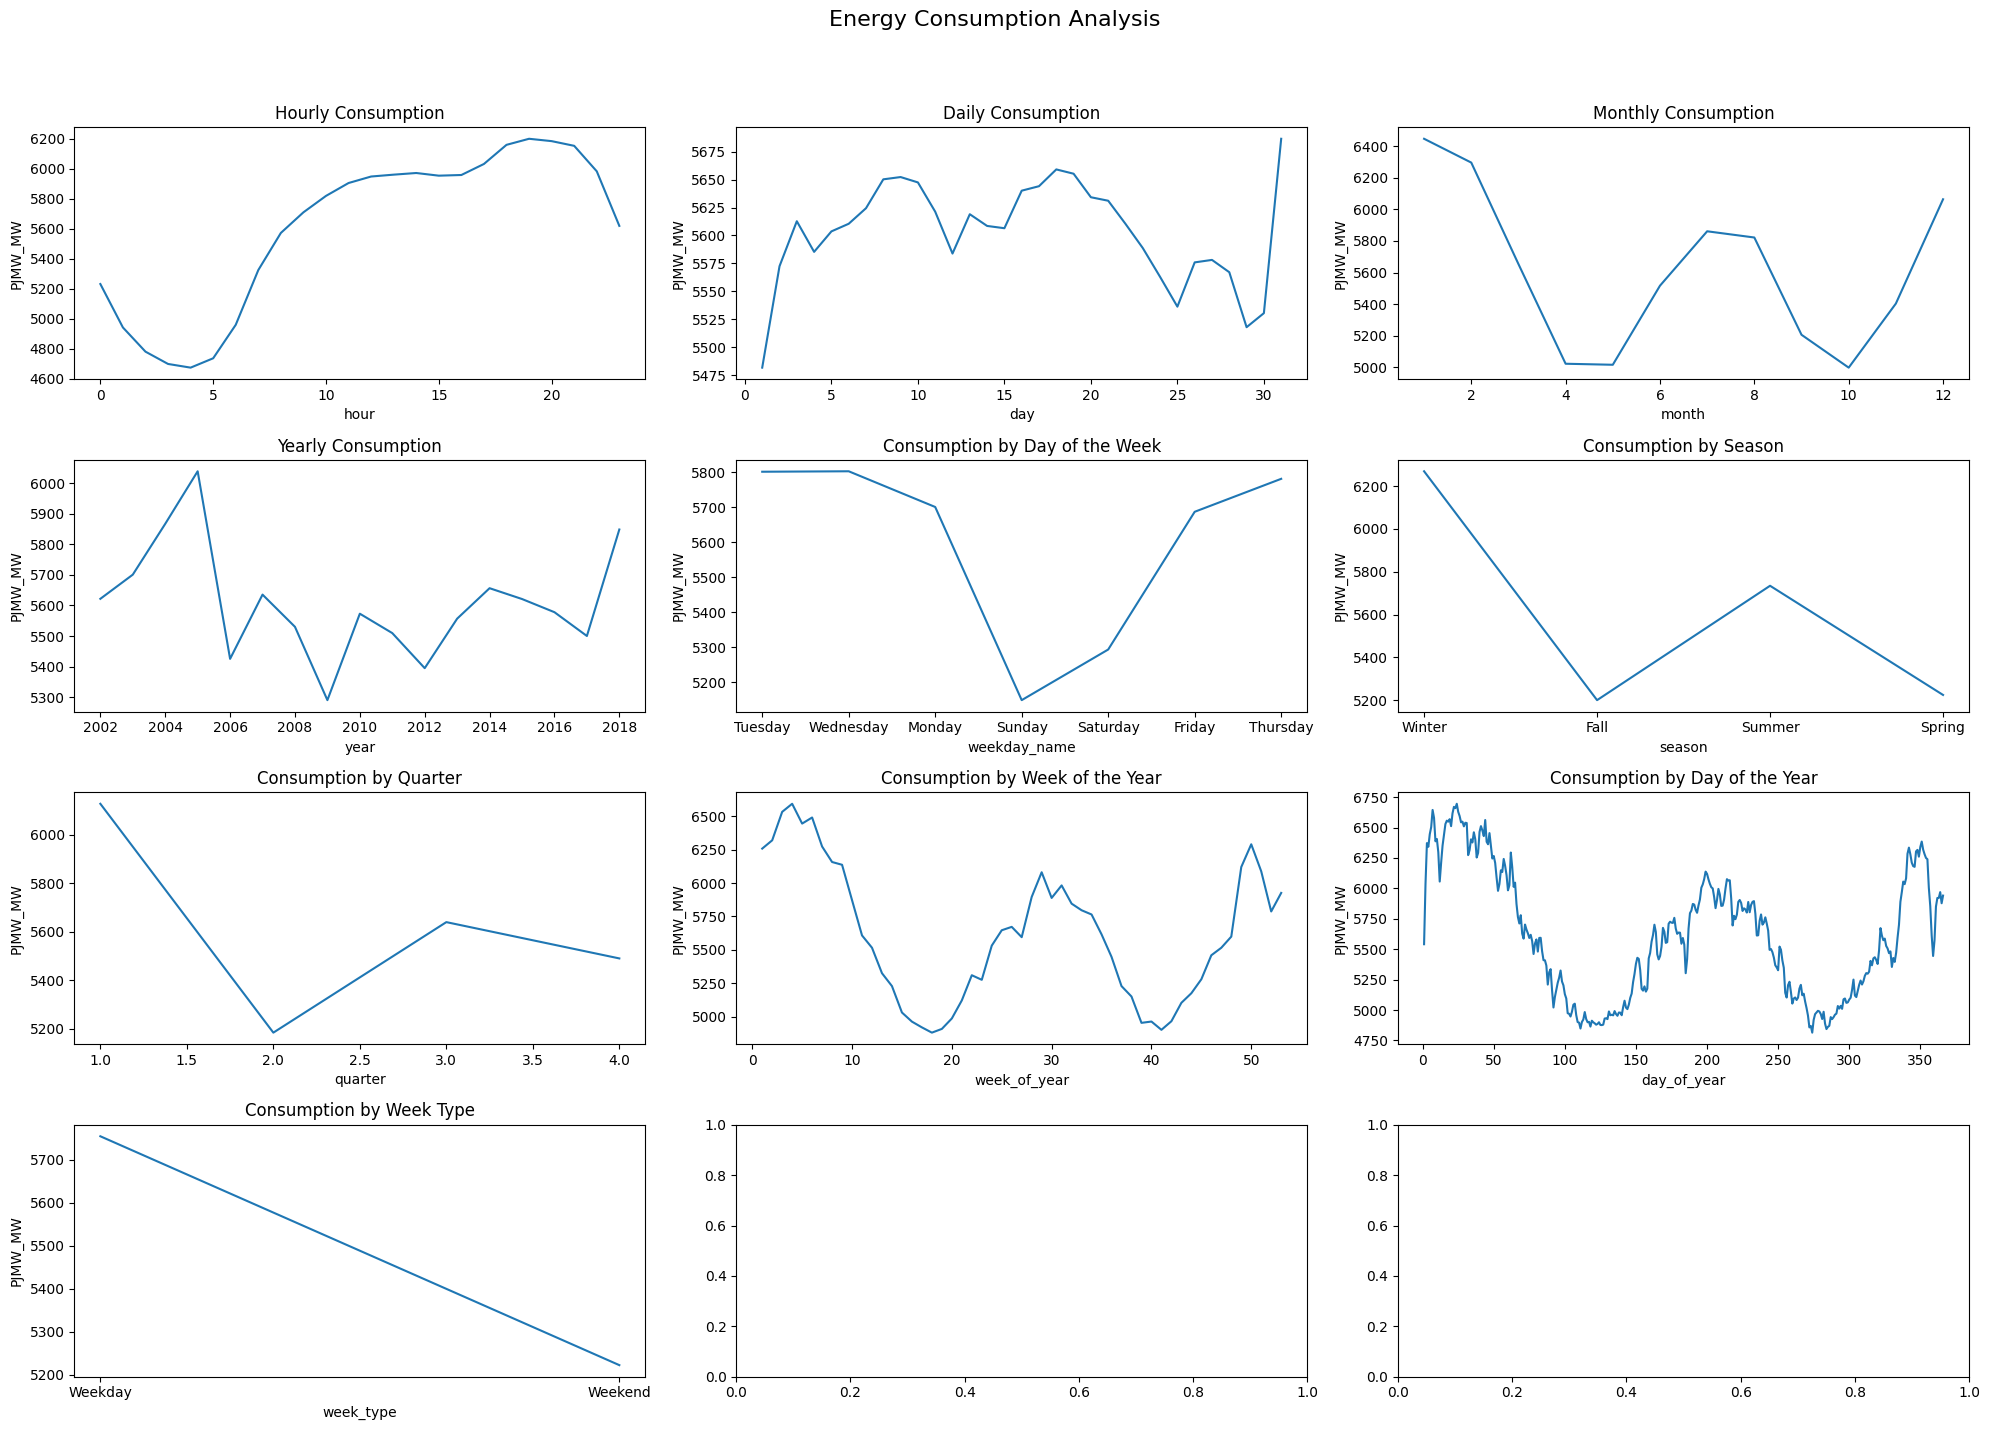

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
fig.suptitle('Energy Consumption Analysis', fontsize=16)


# Hourly consumption
sns.lineplot(ax=axes[0, 0], data=power_forecasting, x='hour', y='PJMW_MW', ci=None)
axes[0, 0].set_title('Hourly Consumption')

# Daily consumption
sns.lineplot(ax=axes[0, 1], data=power_forecasting, x='day', y='PJMW_MW', ci=None)
axes[0, 1].set_title('Daily Consumption')

# Monthly consumption
sns.lineplot(ax=axes[0, 2], data=power_forecasting, x='month', y='PJMW_MW', ci=None)
axes[0, 2].set_title('Monthly Consumption')

# Yearly consumption
sns.lineplot(ax=axes[1, 0], data=power_forecasting, x='year', y='PJMW_MW', ci=None)
axes[1, 0].set_title('Yearly Consumption')

# Consumption by day of the week
sns.lineplot(ax=axes[1, 1], data=power_forecasting, x='weekday_name', y='PJMW_MW', ci=None)
axes[1, 1].set_title('Consumption by Day of the Week')

# Consumption by season
sns.lineplot(ax=axes[1, 2], data=power_forecasting, x='season', y='PJMW_MW', ci=None)
axes[1, 2].set_title('Consumption by Season')

# Consumption by quarter
sns.lineplot(ax=axes[2, 0], data=power_forecasting, x='quarter', y='PJMW_MW', ci=None)
axes[2, 0].set_title('Consumption by Quarter')

# Consumption by week of the year
sns.lineplot(ax=axes[2, 1], data=power_forecasting, x='week_of_year', y='PJMW_MW', ci=None)
axes[2, 1].set_title('Consumption by Week of the Year')

# Consumption by day of the year
sns.lineplot(ax=axes[2, 2], data=power_forecasting, x='day_of_year', y='PJMW_MW', ci=None)
axes[2, 2].set_title('Consumption by Day of the Year')

# Consumption by week type (weekday/weekend)
sns.lineplot(ax=axes[3, 0], data=power_forecasting, x='week_type', y='PJMW_MW', ci=None)
axes[3, 0].set_title('Consumption by Week Type')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


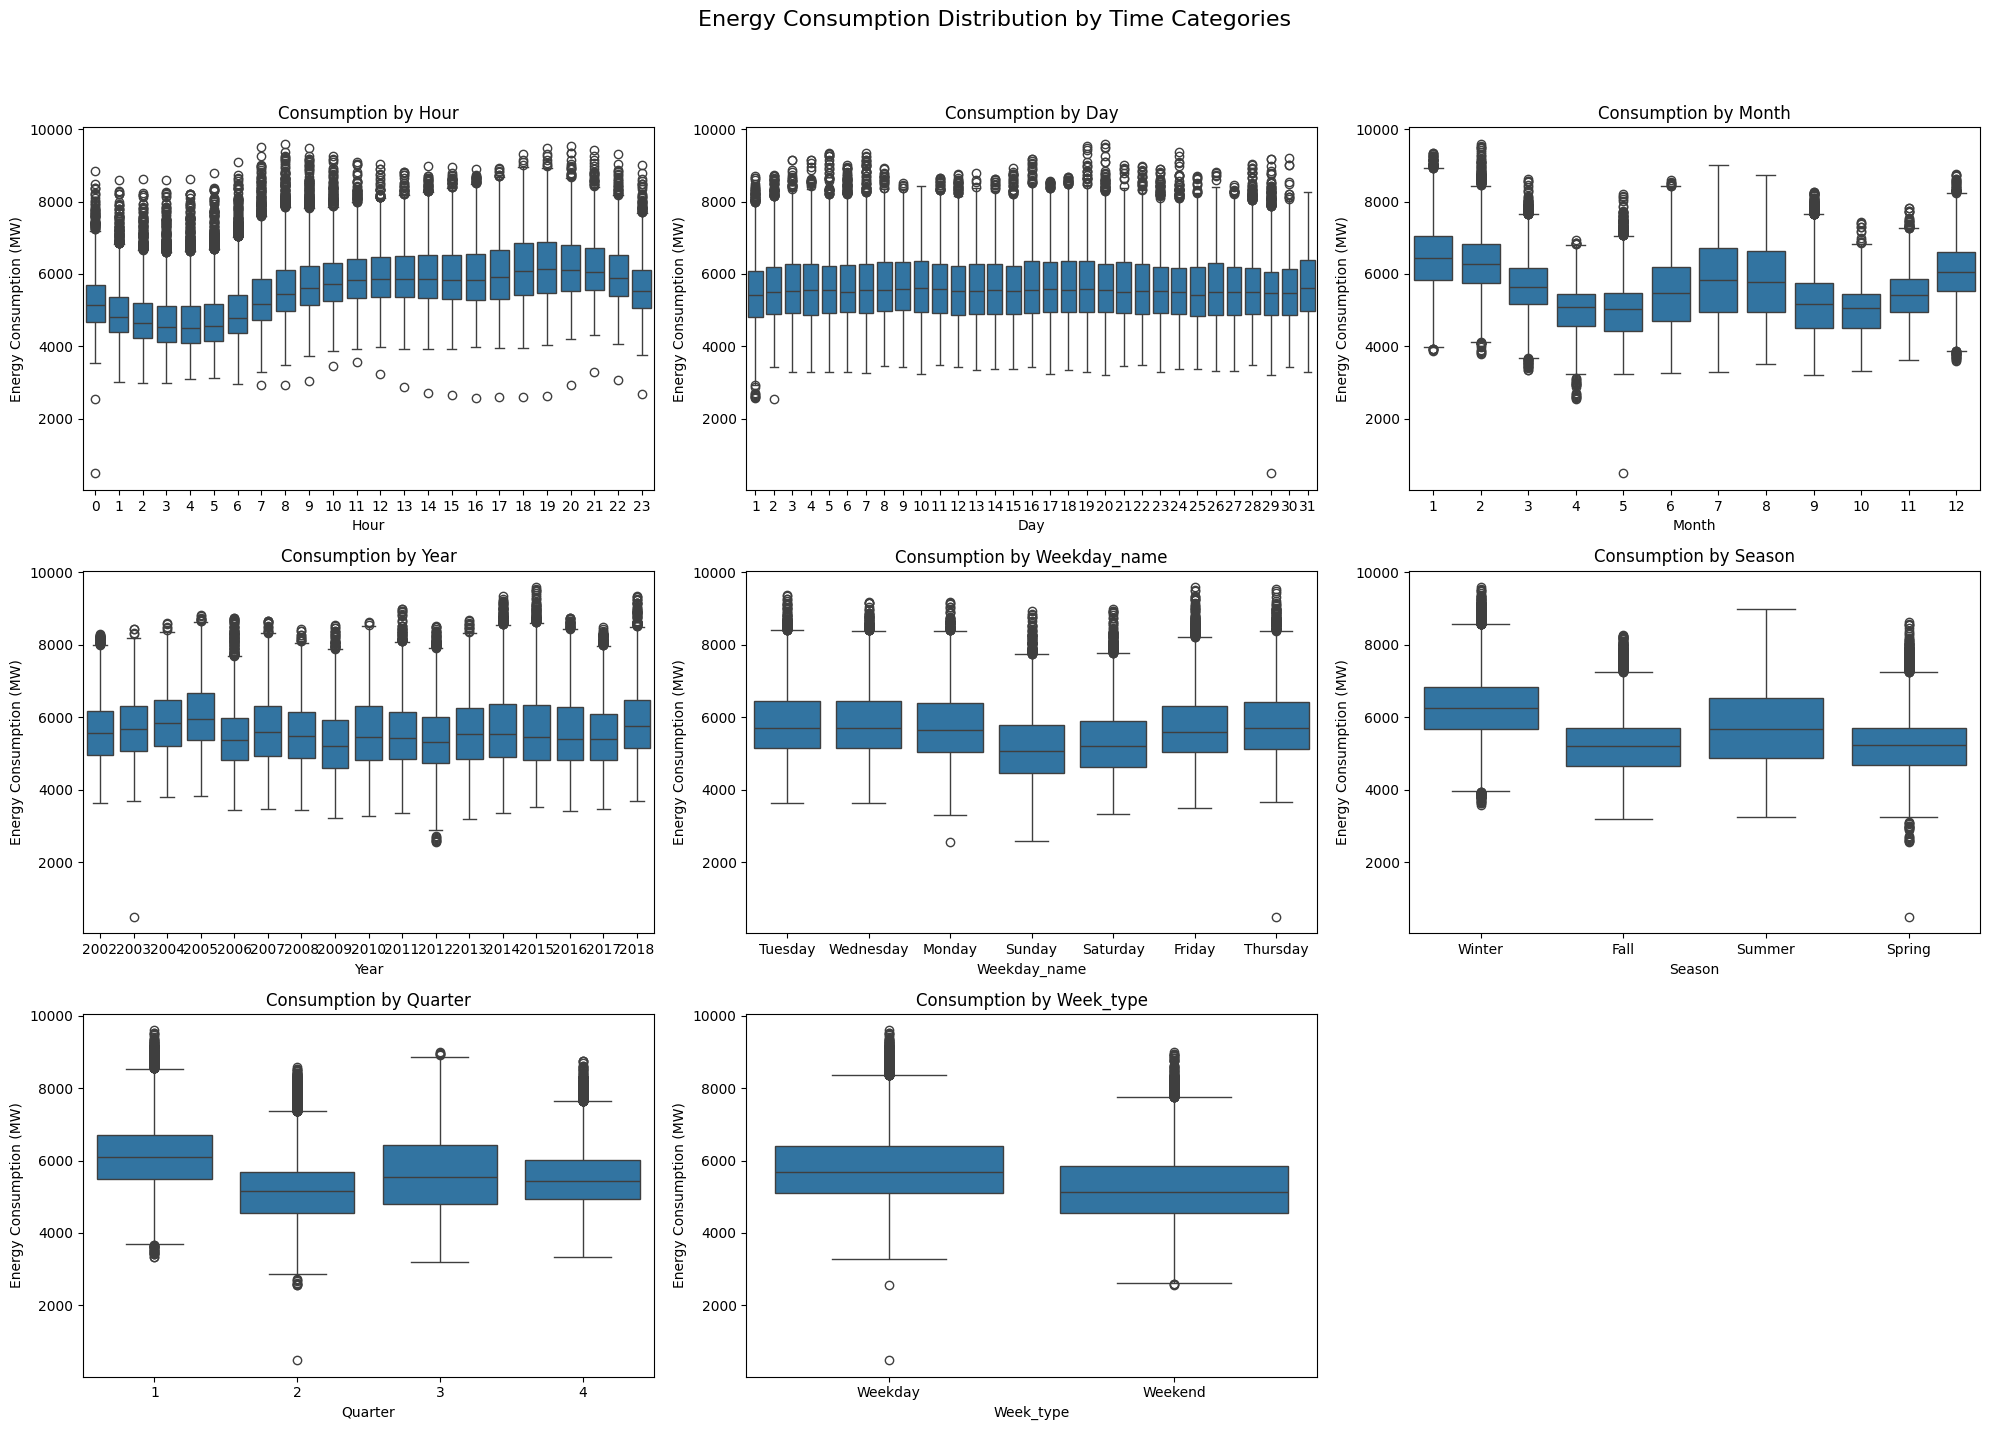

In [18]:
columns = ['hour', 'day', 'month', 'year', 'weekday_name', 'season', 'quarter', 'week_of_year', 'day_of_year', 'week_type']


def is_low_cardinality(column):
    return power_forecasting[column].nunique() < 50

low_cardinality_columns = [col for col in columns if is_low_cardinality(col)]

n_cols = 3
n_rows = (len(low_cardinality_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('Energy Consumption Distribution by Time Categories', fontsize=16)

# Plot boxplots for each low cardinality time period dimension
for ax, col in zip(axes.flat, low_cardinality_columns):
    sns.boxplot(ax=ax, data=power_forecasting, x=col, y='PJMW_MW')
    ax.set_title(f'Consumption by {col.capitalize()}')
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Energy Consumption (MW)')

# Hide any empty subplots
for i in range(len(low_cardinality_columns), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()